In [1]:
# imports
import numpy
from matplotlib import pyplot, rcParams
%matplotlib inline
rcParams['font.family'] = 'serif'
rcParams['font.size'] = '14'
colors = ['#5573a9', '#d4ba95', '#a27f47', '#020c0d']

### Laplace Equation

#### 1. Grid Convergence

We first use a set of tight parameters (high $p$, high $k$, small tolerance) to reveal the discretization error. We compute the potentials at some exterior points for different number of panels, and compare them to their analytical solutions.

**tight parameters, fixed-p**:

| `N` | 128-131072  |
|---|:---:|
| `k` | 13 |
| `ncrit` | 400 |
| `p` | 20 |
| `tol` | 1e-10 |


We set $n_{crit}$ (the maximum number of particles in a leaf) to 400 since it gives a well-balanced P2P vs M2L for three larger cases without relaxation.

In [2]:
# grid convergence at various exterior points
# fixed-p, tight parameters
recur = numpy.arange(3, 9)
N = 2*4**recur

# exterior point a = (3, 3, 3)
e_ext_a = numpy.zeros((2, len(N)))
# 1st-kind
e_ext_a[0,:] = numpy.array([3.4071e-02, 8.9945e-03, 2.3178e-03, \
                            5.9768e-04, 1.5691e-04, 4.2748e-05])
# 2nd-kind
e_ext_a[1,:] = numpy.array([6.2776e-02, 1.6136e-02, 4.0271e-03, \
                            9.9279e-04, 2.4107e-04, 5.6753e-05])

# exterior point b = (-7, 2, -5)
e_ext_b = numpy.zeros((2, len(N)))
# 1st-kind
e_ext_b[0,:] = numpy.array([3.4061e-02, 8.9917e-03, 2.3170e-03, \
                            5.9747e-04, 1.5679e-04, 4.2738e-05])
# 2nd-kind
e_ext_b[1,:] = numpy.array([6.2771e-02, 1.6134e-02, 4.0267e-03, \
                            9.9271e-04, 2.4105e-04, 5.6752e-05])

# exterior point c = (5, -3, -4)
e_ext_c = numpy.zeros((2, len(N)))
# 1st-kind
e_ext_c[0,:] = numpy.array([3.4063e-02, 8.9922e-03, 2.3172e-03, \
                            5.9751e-04, 1.5681e-04, 4.2740e-05])
# 2nd-kind
e_ext_c[1,:] = numpy.array([6.2772e-02, 1.6135e-02, 4.0268e-03, \
                            9.9272e-04, 2.4105e-04, 5.6752e-05])

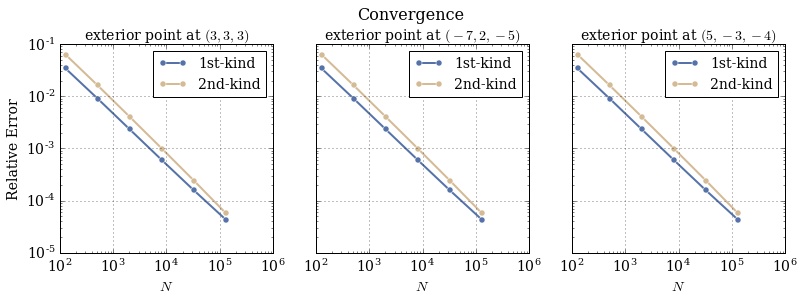

In [3]:
# plot
fig = pyplot.figure(figsize=(13,4), dpi=100)
fig.suptitle("Convergence", fontsize=16)
fig.subplots_adjust(top=0.85)

ax1 = fig.add_subplot(131)
ax1.loglog(N, e_ext_a[0,:], c=colors[0], marker='o', \
           lw=2, ls='-', ms=6, mec='w', label='1st-kind')
ax1.loglog(N, e_ext_a[1,:], c=colors[1], marker='o', \
           lw=2, ls='-', ms=6, mec='w', label='2nd-kind')
ax1.legend(loc='best', fontsize=14)
ax1.grid('on')
ax1.set_xlabel('$N$')
ax1.set_ylabel('Relative Error')
ax1.set_title('exterior point at $(3, 3, 3)$', fontsize=14)

ax2 = fig.add_subplot(132)
ax2.loglog(N, e_ext_b[0,:], c=colors[0], marker='o', \
           lw=2, ls='-', ms=6, mec='w', label='1st-kind')
ax2.loglog(N, e_ext_b[1,:], c=colors[1], marker='o', \
           lw=2, ls='-', ms=6, mec='w', label='2nd-kind')
ax2.legend(loc='best', fontsize=14)
ax2.grid('on')
ax2.set_xlabel('$N$')
ax2.set_yticklabels([])
ax2.set_title('exterior point at $(-7, 2, -5)$', fontsize=14)

ax3 = fig.add_subplot(133)
ax3.loglog(N, e_ext_c[0,:], c=colors[0], marker='o', \
           lw=2, ls='-', ms=6, mec='w', label='1st-kind')
ax3.loglog(N, e_ext_c[1,:], c=colors[1], marker='o', \
           lw=2, ls='-', ms=6, mec='w', label='2nd-kind')
ax3.legend(loc='best', fontsize=14)
ax3.grid('on')
ax3.set_xlabel('$N$')
ax3.set_yticklabels([])
ax3.set_title('exterior point at $(5, -3, -4)$', fontsize=14);

We tested grid convergence with respect to potentials at different exterior points, showing that **the choice of this point doesn't affect the observed convergence rate of our BEM solver**. Thus, in the following speedup test, we only report the relative error of the potential at point $(3,3,3)$ for each case.

In the convergence study above, we used strict parameters ($k=13$, $p=20$, $tol=10^{-10}$) since the discretization error should dominate other errors (even for the largest mesh). Now, we carefully slacken these parameters ($k, p, tol$) one at a time until we see a decrease in accuracy. After we determine the slackest $k,p,tol$ (without affecting the accuracy), we choose the optimal $n_{crit}$s for both cases with and without relaxation. 

We tabulate these parameters below and use them later in performance test to get a modest speedup. 

#### loose parameters, fixed-p
| N | 8192 | 32768 | 131072 |
|---|:---:|:---:|:---:|:---:|:---:|:---:|
| k |  4 | 4 | 4 |
| `p` | 8 | 10 | 10 |
| `tol` | 1e-6 | 1e-6 | 1e-6 |
|`ncrit` (1st-kind)| 300 | 400 | 500 |
|`ncrit` (2nd-kind)| 300 | 400 | 500 |

#### loose parameters, relaxed-p
| N | 8192 | 32768 | 131072 |
|---|:---:|:---:|:---:|:---:|:---:|:---:|
| k |  4 | 4 | 4 |
| `p_init` | 8 | 10 | 10 |
| `tol` | 1e-6 | 1e-6 | 1e-6 |
|`ncrit` (1st-kind)| 100 | 100 | 200 |
|`ncrit` (2nd-kind)| 300 | 300 | 300 |

For three smaller test cases ($N=128, 512, 2048$), the problem size is too small (solving time is within 1 second) to show the benefit of relaxation, therefore, we will neither list the loose parameters for these cases, nor include them in the speedup test.

We repeat the convergence test by using the loosened parameters for both fixed-p and relaxed-p cases as the figure below. The relative errors from using loose parameters are very close to those from the tight parameter settings. So we are convinced that 1). using slack parameters in speedup test is reasonable and 2). our relaxation strategy on GMRES will not affect the final accuracy. We will tabulate these relative errors along with their performance again in the speedup section.

In [4]:
# 1st-kind
ef1_l = numpy.array([6.165e-04, 1.690e-04, 4.935e-05])
er1_l = numpy.array([6.128e-04, 1.703e-04, 5.055e-05])    # only for three larger grids
# 2nd-kind
ef2_l = numpy.array([9.739e-04, 2.290e-04, 5.014e-05])
er2_l = numpy.array([9.739e-04, 2.289e-04, 4.973e-05])

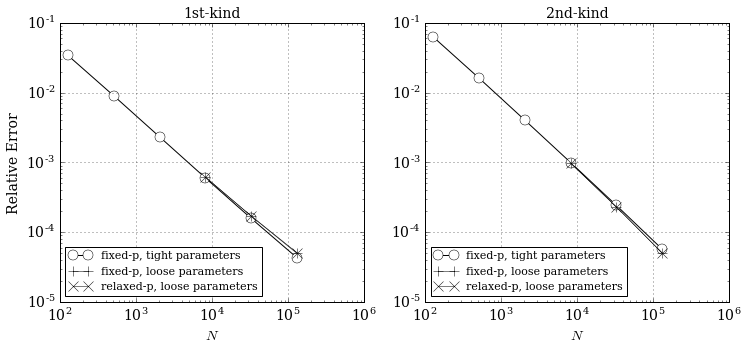

In [5]:
# plot convergence
fig = pyplot.figure(figsize=(12,5), dpi=100)

ax1 = fig.add_subplot(121)
ax1.loglog(N, e_ext_a[0,:], c='k', ls='-', lw=1.0, marker='o', \
           mfc='w', ms=10, label='fixed-p, tight parameters')
# loose params
ax1.loglog(N[-3:], ef1_l, c='k', ls='-', lw=0.5, marker='+', \
           ms=10, label='fixed-p, loose parameters')
ax1.loglog(N[-3:], er1_l, c='k', ls='-', lw=0.5, marker='x', \
           ms=10, label='relaxed-p, loose parameters')
ax1.set_xlabel('$N$', fontsize=14)
ax1.set_ylabel('Relative Error')
ax1.legend(loc=3, fontsize=11)
ax1.grid('on')
ax1.set_title('1st-kind', fontsize=14)

ax2 = fig.add_subplot(122)
ax2.loglog(N, e_ext_a[1,:], c='k', ls='-', lw=1.0, marker='o', \
           mfc='w', ms=10, label='fixed-p, tight parameters')
# loose params
ax2.loglog(N[-3:], ef2_l, c='k', ls='-', lw=0.5, marker='+', \
           ms=10, label='fixed-p, loose parameters')
ax2.loglog(N[-3:], er2_l, c='k', ls='-', lw=0.5, marker='x', \
           ms=10, label='relaxed-p, loose parameters')
ax2.set_xlabel('$N$', fontsize=14)
ax2.legend(loc=3, fontsize=11)
ax2.grid('on')
ax2.set_title('2nd-kind', fontsize=14);

#### the observed order of convergence

In [6]:
r = 4    # grid size ratio
print("1st-kind formulation")
print(numpy.log((e_ext_a[0,2]-e_ext_a[0,3])/
                (e_ext_a[0,3]-e_ext_a[0,4]))/numpy.log(r))
print("2nd-kind formulation")
print(numpy.log((e_ext_a[1,2]-e_ext_a[1,3])/
                (e_ext_a[1,3]-e_ext_a[1,4]))/numpy.log(r))

1st-kind formulation
0.982205637964
2nd-kind formulation
1.00655059631


-------------

#### 2. Residual vs Iterations plot

- problem size: $N = 32,768$
- using loose parameters: $k = 4$, $tol = 10^{-6}$, $n_{crit}=100$ and two different $p$ s: $p_{initial} = \{8 ,10 \}$

The figure below shows how residual and required-p change as iterations proceeds. We use $p=10$ and $p=8$ separately, other parameters ($k$, $tol$) are chosen from loose parameter set, and $n_{crit}$ is optimal. 

In [7]:
result_p8 = numpy.genfromtxt('./resources/LaplaceResidualP_p8', dtype=None)
result_p10 = numpy.genfromtxt('./resources/LaplaceResidualP_p10', dtype=None)
r_p8 = numpy.empty(result_p8.shape[0])
p_p8 = numpy.empty(result_p8.shape[0])
r_p10 = numpy.empty(result_p10.shape[0])
p_p10 = numpy.empty(result_p10.shape[0])
# parse residual and required-p
for i in range(result_p8.shape[0]-1):
    r_p8[i] = float(result_p8[i, 3].decode('UTF-8')[:-1])
    p_p8[i] = float(result_p8[i, -1].decode('UTF-8'))
# last iteration
r_p8[-1] = float(result_p8[-1, 2].decode('UTF-8')[:-1])
p_p8[-1] = 1

# parse residual and required-p
for i in range(result_p10.shape[0]-1):
    r_p10[i] = float(result_p10[i, 3].decode('UTF-8')[:-1])
    p_p10[i] = float(result_p10[i, -1].decode('UTF-8'))
# last iteration
r_p10[-1] = float(result_p10[-1, 2].decode('UTF-8')[:-1])
p_p10[-1] = 1

In [8]:
# iteration number
ind1 = numpy.arange(len(r_p8), dtype=int) + 1
ind2 = numpy.arange(len(r_p10), dtype=int) + 1

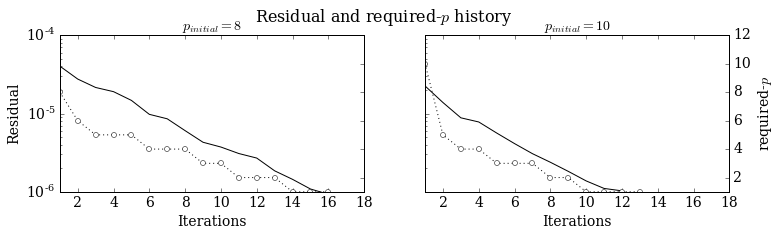

In [9]:
# plot
fig = pyplot.figure(figsize=(12,3), dpi=100)
fig.suptitle("Residual and required-$p$ history", fontsize=16)
fig.subplots_adjust(top=0.85)
# left plot
ax1 = fig.add_subplot(121)
# plot residual
ax1.semilogy(ind1,r_p8,color='k',marker='', ls='-', mfc='w', ms=5)
# plot required-p
ax2 = ax1.twinx()
ax2.plot(ind1,p_p8,color='k',marker='o',ls=':', mfc='w', ms=5)
# axis labels
ax1.set_ylabel('Residual', fontsize=14)
ax1.set_xlabel('Iterations', fontsize=14)
ax1.set_ylim(1e-6, 1e-4)
ax2.set_ylim(1,12)
ax2.set_xlim(1,18)
pyplot.setp(ax2.get_yticklabels(), visible=False)
ax1.set_title('$p_{initial} = 8$', fontsize=14)

# right plot
ax3 = fig.add_subplot(122)
# plot residual
ax3.semilogy(ind2,r_p10,color='k',marker='', ls='-', mfc='w', ms=5)
# plot required-p
ax4 = ax3.twinx()
ax4.plot(ind2,p_p10,color='k',marker='o',ls=':', mfc='w', ms=5)
# axis labels
ax3.set_xlabel('Iterations', fontsize=14)
ax3.set_ylim(1e-6, 1e-4)
ax3.set_yticklabels([])
ax4.set_ylabel('required-$p$', fontsize=14)
ax4.set_xlim(1,18)
ax4.set_ylim(1,12)
ax3.set_title('$p_{initial} = 10$', fontsize=14);

#### 3. Speedup Test

We use the slack parameters ($k, p, tol$) and optimal $n_{crit}$ to benchmark our FMM-BEM solver with and without relaxation on a Laplace problem. Time reported below is the average solving time (wall time) of three identical runs. We also report the number of iterations and relative error for each case to verify that relaxation would not affect the accuracy.

#### 1st-kind
|   | fixed-$p$ | | | | relaxed-$p$ | | | | speedup |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N$ | $n_{crit}$ | $t$ | # $iters$ | $err_{rel}$ | $n_{crit}$ | $t$ | # $iters$ | $err_{rel}$ | speedup |
| 8192   | 300 | 3.14 | 11 | 6.165e-04 | 100 | 2.07 | 12 | 6.128e-04 | 1.52 |
| 32768  | 400 | 19.84 | 11 | 1.690e-04 | 100 | 11.48 | 13 | 1.703e-04 | 1.73 |
| 131072 | 500 | 97.37 | 13 | 4.935e-05 | 200 | 43.06 | 14 | 5.055e-05 | 2.26 |

#### 2nd-kind
|   | fixed-$p$ | | | | relaxed-$p$ | | | | speedup |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N$ | $n_{crit}$ | $t$ | # $iters$ | $err_{rel}$ | $n_{crit}$ | $t$ | # $iters$ | $err_{rel}$ | speedup |
| 8192   | 300 | 1.19 | 2 | 9.739e-04 | 300 | 1.00 | 2 | 9.739e-04 | 1.19 |
| 32768  | 400 | 7.10 | 2 | 2.290e-04 | 300 | 5.49 | 2 | 2.289e-04 | 1.29 |
| 131072 | 500 | 27.49 | 2 | 5.014e-05 | 300 | 22.49 | 2 | 4.973e-05 | 1.22 |

-------------

### Stokes Flow on a Sphere

#### 1. Grid Convergence

Similar to the previous section, we first use a set of tight parameters for grid convergence test, where we compare the calculated drag force with its analytical solution. Because of the memory restriction, we cannot use a near-optimal `ncrit=400` for the largest mesh. Therefore, we used the largest possible `ncrit=150` for that case.

#### tight parameters, fixed-p:

| `N` | 128-32768 | 131072 |
|---|:---:|:---:|
| `k` | 13 | 13 |
| `ncrit` | 400 | 150 |
| `p` | 20 | 20 |
| `tol` | 1e-10 | 1e-10 |


In [10]:
# fixed-p, tight parameters
ef1 = numpy.array([1.87492e-01, 9.39450e-02, 4.63921e-02, \
                   2.29365e-02, 1.13824e-02, 5.78213e-03])

As we did before, we gradually slacken $k, p, tol$ until the relative error goes up. $n_{crit}$ is chosen to minimize the solving time.

**loose parameters, fixed-p:**

| N | 8192 | 32768 | 131072 |
|---|:---:|:---:|:---:|
| `k` | 4 | 4 | 4 |
|`ncrit`| 300 | 400 | 150 |
| `p` | 12 | 12 | 14 |
| `tol` | 1e-5 | 1e-5 | 1e-5 |

**loose parameters, relaxed-p:**

| N | 8192 | 32768 | 131072 |
|---|:---:|:---:|:---:|
| `k` | 4 | 4 | 4 |
|`ncrit`| 100 | 60 | 80 |
| `p_init` | 12 | 12 | 14 |
| `pmin` | 4 | 3 | 4 |
| `tol` | 1e-5 | 1e-5 | 5e-6 | 


In the loose parameter setting for the relaxed-p cases, we found that we have to enforce a minimum $p$ to preserve the accuracy of the result. We first determine $p_{initial}$, $p_{min}$ and $tol$ required for each case, then find the optimal $n_{crit}$.

In [11]:
# only for three larger grids
ef1_l = numpy.array([2.27493e-02, 1.11135e-02, 5.78213e-03])
er1_l = numpy.array([2.324e-02, 1.110e-02, 6.548e-03])

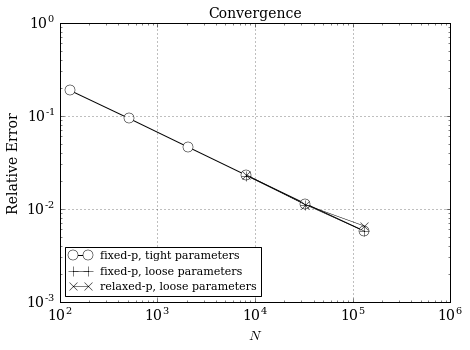

In [12]:
# plot convergence
fig = pyplot.figure(figsize=(7,5), dpi=100)

ax1 = fig.add_subplot(111)
ax1.loglog(N, ef1, c='k', ls='-', lw=1.0, marker='o', \
           mfc='w', ms=10, label='fixed-p, tight parameters')

# loose params
ax1.loglog(N[-3:], ef1_l, c='k', ls='-', lw=0.5, marker='+', \
           ms=10, label='fixed-p, loose parameters')
ax1.loglog(N[-3:], er1_l, c='k', ls='-', lw=0.5, marker='x', \
           ms=8, label='relaxed-p, loose parameters')
ax1.set_xlabel('$N$', fontsize=14)
ax1.set_ylabel('Relative Error')
ax1.legend(loc=3, fontsize=11)
ax1.grid('on')
ax1.set_title('Convergence', fontsize=14);

Again, we compare the accuracy of using loose parameters with the accuracy of using tight parameters as the figure above. These relative errors are tabulated below in the speedup test.

#### 2. Speedup Test


|   | fixed-$p$ | | | | relaxed-$p$ | | | | | speedup |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N$ | $n_{crit}$ | $t$ | # $iters$ | $err_{rel}$ | $n_{crit}$ | $t$ | # $iters$ | $err_{rel}$ | pmin | speedup |
| 8192 | 300 | 82.57 | 27 | 2.275e-02 | 100 | 30.56 | 29 | 2.324e-02 | 4 | 2.70 |
| 32768  | 400 | 370.18 | 27 | 1.111e-02 | 60 | 111.93 | 30 | 1.110e-02 | 3 | 3.31 |
| 131072 | 150 | 3058.93 | 24 | 5.782e-03 | 80 | 682.14 | 34 | 6.548e-03 | 4 | 4.48 |

#### 3. Time Breakdown

In this section, we demonstrate the load balance between near-field and far-field interaction in the relaxed GMRES solver. The case we choose is the optimal case with 32768 panels.

In [13]:
result = numpy.genfromtxt('./resources/StokesSphereBreakdown', dtype=None)
P2P = numpy.empty(result.shape[0])
M2L = numpy.empty(result.shape[0])

In [14]:
for i in range(result.shape[0]):
    P2P[i] = float(result[i, 1].decode('UTF-8')[:-2])
    M2L[i] = float(result[i, -1].decode('UTF-8')[:-1])
P2P_sum = numpy.sum(P2P)
M2L_sum = numpy.sum(M2L)

In [15]:
print("P2P total time:", P2P_sum)
print("M2L total time:", M2L_sum)

P2P total time: 61.415
M2L total time: 47.582


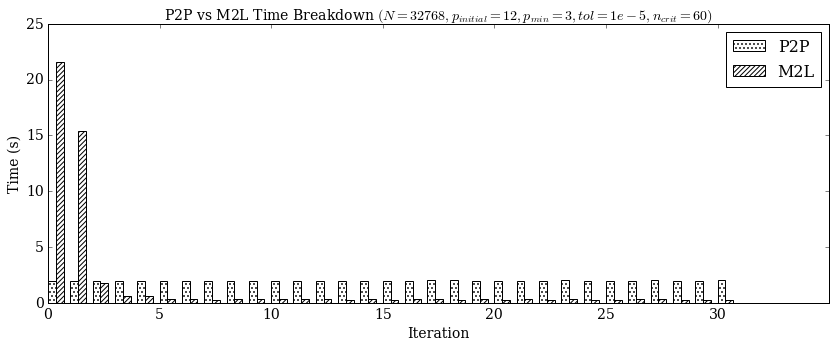

In [16]:
# plot
fig = pyplot.figure(figsize=(14,5), dpi=80)
ax = fig.add_subplot(111)

ind = numpy.arange(len(P2P))
width = 0.35

# plot bars
bar1 = ax.bar(ind, P2P, width, fill=False, edgecolor='k', hatch='.'*3, linewidth=1)
bar2 = ax.bar(ind+width, M2L, width, fill=False, edgecolor='k', hatch='/'*5, linewidth=1)

# axis labels
ax.set_ylabel('Time (s)', fontsize=14)
ax.set_xlabel('Iteration', fontsize=14)
pyplot.xticks(numpy.arange(min(ind), max(ind)+1, 5.0))
ax.legend( (bar1[0], bar2[0]), ('P2P', 'M2L'), loc=1, fontsize=16)
ax.set_title('P2P vs M2L Time Breakdown $(N = 32768, p_{initial} = 12, \
              p_{min} = 3, tol = 1e-5, n_{crit}=60)$', fontsize=14);

----------------------

### Stokes Flow on Red Blood Cells

#### 1. Grid Convergence of a single red blood cell

While there is no analytical solution for the Stokes flow around a red blood cell, we use Richardson extrapolation to estimate the analytical solution in this convergence test. For the same reason of memory restriction, we cannot use near-optimal $n_{crit} = 400$ for the largest case. 

**tight parameters, fixed-p:** 

| `N` | 128-32768 | 131072 |
|---|:---:|:---:|
| `k` | 13 | 13 |
| `ncrit` | 400 | 150 |
| `p` | 20 | 20 |
| `tol` | 1e-10 | 1e-10 |

**loose parameters, fixed-p**:

| N | 2048 | 8192 | 32768 | 131072 |
|---|:---:|:---:|:---:|:---:|
| `k` | 4 | 4 | 4 | 4 |
|`ncrit`| 400 | 400 | 400 | 150 |
| `p` | 14 | 14 | 14 | 14 |
| `tol` | 1e-5 | 1e-5 | 1e-5 | 1e-5 |

**loose parameters, relaxed-p:**

| N | 2048 | 8192 | 32768 | 131072 |
|---|:---:|:---:|:---:|:---:|
| `k` | 4 | 4 | 4 | 4 |
|`ncrit`| 130 | 140 | 120 | 100 |
| `p_init` | 14 | 14 | 14 | 14 |
| `pmin` | 3 | 3 | 3 | 3 |
| `tol` | 1e-5 | 1e-5 | 1e-5 | 1e-5 |


In [17]:
f1 = - 0.05705    # 512  panels/cell
f2 = - 0.07032    # 2048 panels/cell
f3 = - 0.07663    # 8192 panels/cell
f4 = - 0.07988    # 32768 panels/cell
f5 = - 0.08141    # 131072 panels/cell
# Richardson Extrapolation
f_bar = (f1*f3 - f2**2) / (f1 - 2*f2 + f3)

In [18]:
f = numpy.array([f1, f2, f3, f4, f5])
err_rel = numpy.abs((f - f_bar)/f_bar)

# fixed-p, loose params
f_f = numpy.array([-0.07033, -0.07678, -0.07989, -0.08141])
e_f = numpy.abs((f_f - f_bar)/f_bar)
# relax-p, loose params
f_r = numpy.array([-0.07010, -0.07780, -0.07977, -0.08149])
e_r = numpy.abs((f_r - f_bar)/f_bar)

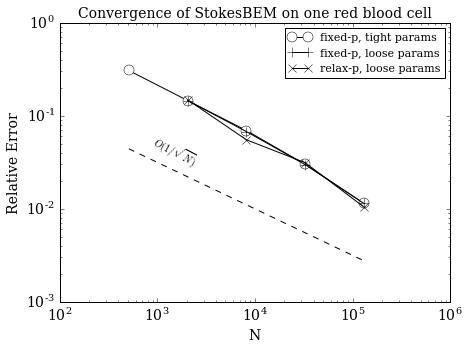

In [19]:
# set up data
N = numpy.array([512, 2048, 8192, 32768, 131072])
line_sqrtN = 1 / numpy.sqrt(N)

# set up plot
fig = pyplot.figure(figsize=(7,5), dpi=100)
ax = fig.add_subplot(111)

# plot log-log
ax.loglog(N,err_rel,c='k',marker='o', ls='-', mfc='w',\
          ms=10, label='fixed-p, tight params')
ax.loglog(N[1:], e_f, c='k', marker='+', ls='-', ms=10, \
          label='fixed-p, loose params')
ax.loglog(N[1:], e_r, c='k', marker='x', ls='-', ms=8, \
          label='relax-p, loose params')
ax.loglog(N,line_sqrtN,c='k',ls='--', mfc='w', ms=10)
ax.legend(loc='best', fontsize=11)

loc = (3*N[0]+N[1])/4
# text on plot: 1/sqrt(N)
tex_loc = numpy.array((loc,N[0]*err_rel[0]/loc))
ax.text(tex_loc[0], tex_loc[1]/3.5,r'$O(1/\sqrt{N})$',fontsize=10,rotation=-28, rotation_mode='anchor')
# axis labels
ax.set_ylabel('Relative Error', fontsize=14)
ax.set_xlabel('N', fontsize=14)
ax.set_title('Convergence of StokesBEM on one red blood cell', fontsize=14);

The results from using loose parameters match well with those from using tight parameters.

#### 2. Speedup Test

We use loose parameters with optimal $n_{crit}$ to measure the speedup. Due to the lack of analytical solution, we report the calculated drag force for each run.

**single red blood cell**

|   | fixed-$p$ | | | | relaxed-$p$ | | | | | speedup |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | pmin | speedup |
| 2048 | 400 | 33.64 | 35 | -0.07033 | 130 | 11.21 | 37 | -0.07010 | 3 | 3.00 |
| 8192 | 400 | 183.73 | 39 | -0.07678 | 140 | 64.92 | 41 | -0.07780 | 3 | 2.83 |
| 32768 | 400 | 809.90 | 35 | -0.07989 | 120 | 253.90 | 39 | -0.07977 | 3 | 3.19 |
| 131072  | 150 | 4407.47 | 31 | -0.08141 | 100 | 980.65 | 35 | -0.08149 | 3 | 4.49 |

**2048 panels/cell** 

|   | | fixed-$p$ | | | | relaxed-$p$ | | | | | speedup |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N_{panels}$ | $N_{cells}$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | pmin | speedup |
| 2048 | 1 | 400 | 33.64 | 35 | -0.07033 | 130 | 11.21 | 37 | -0.07010 | 3 | 3.00 |
| 8192 | 4 | 400 | 204.43 | 51 | -0.19825 | 140 | 87.34 | 52 | -0.19765 | 3 | 2.34 |
| 32768 | 16 | 400 | 1128.50 | 67 | -0.67816 | 100 | 466.12 | 70 | -0.67270 | 3 | 2.42 |
| 131072  | 64 | 150 | 6186.23 | 76 | -2.41785 | 120 | 1953.23 | 79 | -2.41026 | 3 | 3.17 |

**8192 panels/cell** 

|   |  | fixed-$p$ | | | | relaxed-$p$ | | | | | speedup |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N_{panels}$ | $N_{cells}$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | pmin | speedup |
| 8192 | 1 | 400 | 183.73 | 39 | -0.07678 | 140 | 64.92 | 41 | -0.07780 | 3 | 2.83 |
| 32768 | 4 | 400 | 1300.30 | 54 | -0.21589 | 120 | 423.83 | 55 | -0.21703 | 3 | 3.07 |
| 131072  | 16 | 150 | 8837.73 | 67 | -0.73883 | 100 | 2097.87 | 68 | -0.73841 | 4 | 4.21 |

**32768 panels/cell** 

|   |  | fixed-$p$ | | | | relaxed-$p$ | | | | | speedup |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N_{panels}$ | $N_{cells}$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | $n_{crit}$ | $t$ | # $iters$ | $f_x$ | pmin | speedup |
| 32768 | 1 | 400 | 809.90 | 35 | -0.07989 | 120 | 253.90 | 39 | -0.07977 | 3 | 3.19 |
| 131072  | 4 | 150 | 6171.47 | 49 | -0.22452 | 120 | 1599.33 | 51 | -0.22450 | 3 | 3.86 |

-------------

### Appendix

#### a. how do we determine $p$ or how does $p$/$p_{initial}$ affect the solver's accuracy?

In this section, we show how we determine $p$ for each case. Here we take Laplace equation with Dirichlet boundary condition (1st-kind Fredholm integral equation) as an example. Suppose we fix $k$ at 4 and $tol$ at 1e-6, then we use a set of $p$ ranging from 3 to 15 (with a step of 3). For each $p$, we measure two quantities: 1). the l2 norm of the relative error of $\frac{\partial \Phi}{\partial n}$ at collocation points (these are the unknowns of the BEM system of linear equations) 2). the relative error of the potential at an exterior point (the quantity of interest, which is a integral quantity based on $\Phi$ s and $\frac{\partial \Phi}{\partial n}$ s at the collocation points on the surface). 

For each problem size $N$, we plot two relative errors against the changing p in the figure below. As we can see, the accuracy of $\frac{\partial \Phi}{\partial n}$ at the collocation points (left figure) increases as we uses a higher $p$ for each problem size. For the largest case ($N=131072$), the discretization error is so tiny that we can still improve the accuracy with a $p>15$. The figure on the right gives you the relative error of the potential at an exterior point $(3,3,3)$. The relative error of this integral quantity saturates at $p \approx 8$ for $N=8192$, and at $p \approx 10$ for $N = 32768, 131072$. That is how we choose the loosen $p$ for Laplace equation.

In [20]:
# 1st-kind, ext: at the exterior point, bd: on the boundary
p_set = numpy.linspace(3, 15, 5)

e_ext_r6 = numpy.array([2.0252e-03, 5.9882e-04, 6.2378e-04, \
                        6.1648e-04, 6.1949e-04])
e_bd_r6  = numpy.array([7.404e-02, 7.759e-03, 1.943e-03, \
                        1.909e-03, 1.896e-03])
e_ext_r7 = numpy.array([1.3735e-03, 1.1347e-04, 1.7347e-04, \
                        1.6886e-04, 1.6808e-04])
e_bd_r7  = numpy.array([2.914e-01, 1.509e-02, 1.943e-03, \
                        7.638e-04, 7.500e-04])
e_ext_r8 = numpy.array([1.5832e-03, 6.8753e-06, 5.2404e-05, \
                        4.9622e-05, 4.8365e-05])
e_bd_r8  = numpy.array([7.834e-01, 4.536e-02, 4.423e-03, \
                        4.443e-04, 1.890e-04])

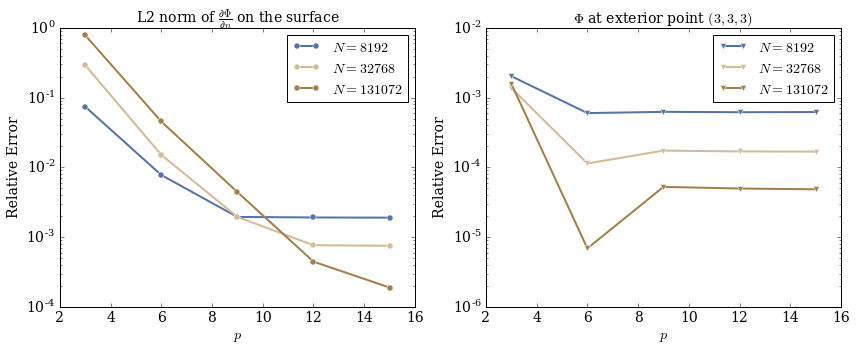

In [21]:
# plot
fig = pyplot.figure(figsize=(14,5), dpi=100)
ax1 = fig.add_subplot(121)
ax1.plot(p_set, e_bd_r6, c=colors[0], marker='o', \
         lw=2, ls='-', ms=6, mec='w', label='$N = 8192$')
ax1.plot(p_set, e_bd_r7, c=colors[1], marker='o', \
         lw=2, ls='-', ms=6, mec='w', label='$N = 32768$')
ax1.plot(p_set, e_bd_r8, c=colors[2], marker='o', \
         lw=2, ls='-', ms=6, mec='w', label='$N = 131072$')
ax1.set_xlim(2, 16)
ax1.set_yscale('log')
ax1.set_xlabel('$p$')
ax1.set_ylabel('Relative Error')
#ax1.text(12, e_fixed_7[-2]*1.2, 'N = 32768', fontsize = 12)
#ax1.text(12, e_fixed_6[-2]*1.2, 'N = 8192', fontsize = 12)
ax1.legend(loc=1, fontsize=14)
ax1.set_title(r'L2 norm of $\frac{\partial \Phi}{\partial n}$ on the surface', fontsize=14)

ax2 = fig.add_subplot(122)
ax2.plot(p_set, e_ext_r6, c=colors[0], marker='v', \
         lw=2, ls='-', ms=6, mec='w', label='$N = 8192$')
ax2.plot(p_set, e_ext_r7, c=colors[1], marker='v', \
         lw=2, ls='-', ms=6, mec='w', label='$N = 32768$')
ax2.plot(p_set, e_ext_r8, c=colors[2], marker='v', \
         lw=2, ls='-', ms=6, mec='w', label='$N = 131072$')
ax2.set_xlim(2, 16)
ax2.set_yscale('log')
ax2.set_xlabel('$p$')
ax2.set_ylabel('Relative Error')
ax2.legend(loc=1, fontsize=14)
ax2.set_title('$\Phi$ at exterior point $(3,3,3)$', fontsize=14);

#### b. Performance of our FMM code compared to other FMM libraries

<img src='./resources/FMMlibPerformance.png'>

This figure is from Dr. Yokota's paper: [An FMM Based on Dual Tree Traversal for Many-core Architecture](http://act.sagepub.com/content/7/3/301.full.pdf+html). The plot shows the timings of different FMM codes to solve a Laplace kernel where particles are randomly distributed in a cube. These benchmarks were tested on a hexa-core Xeon X5650 CPU.

We benchmark our FMM solver using a Laplace kernel with randomly distributed particles in a unit cube. We set $p=5$, $\theta_{MAC} = 0.5$, $n_{crit} = 125$ (optimal), and perform these benchmarks using different number of particles on a lab workstation with an Intel Core i7-5930K hexa-core processor. We list the results below.

| N | $t_{solve}$ (s) |  
|---|:---:|:---:|:---:|
| $10^4$ | 1.030e-01 |
| $10^5$ | 1.160e+00 |
| $10^6$ | 9.367e+00 |

Despite the fact that the hardware and the choice of $p$, $\theta_{MAC}$ are not strictly same as those in Yokota's test, our FMM performance falls into the range which was reported in his paper, showing that at least our FMM implementation is moderately efficient.